# Template for reinforcement learning applied to the CartPole benchmark

A lot of (better) code taken from https://github.com/ageron/handson-ml

# Settings

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import gym
import numpy as np
import bisect
import math
import os
import random
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.WARN)  # Remove Info logs

/home/remy/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.make("CartPole-v1")

In [3]:
print(env.action_space)  # 0 or 1

obs = env.reset()
print(obs)  # position, velocity, angle, angular_velocity
print(env._max_episode_steps)

Discrete(2)
[-0.04801312  0.02100851  0.039331    0.01487233]
500


# Random policy

In [ ]:
def run_episode_random_agent():    
    obs = env.reset()
    done = False
    final_score = 0

    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        final_score += reward
    return final_score

In [ ]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_random_agent()
    scores.append(episode_score)

In [ ]:
print(np.mean(scores))
plt.plot(scores)

# Human crafted policy

In [ ]:
def human_decision(angle):
    if angle < 0:
        action = 0  # move Cart to left
    else:
        action = 1  # move Cart to right
    return action

In [ ]:
def run_episode_human_crafted_agent(): 
    obs = env.reset()
    done = False
    final_score = 0

    while not done:
        position, velocity, angle, angular_velocity = obs
        action = human_decision(angle)
        obs, reward, done, info = env.step(action)

        final_score += reward
    return final_score

In [ ]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_human_crafted_agent()
    scores.append(episode_score)

In [ ]:
print(np.mean(scores))
plt.plot(scores)

# Q-learning

## Observing the values

In [ ]:
nb_episodes = 1000
positions = []
velocities = []
angles = []
angular_velocities = []

for episode in range(0, nb_episodes):
    obs = env.reset()
    done = False
    final_score = 0

    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        position, velocity, angle, angular_velocity = obs
        positions.append(position)
        velocities.append(velocity)
        angles.append(angle)
        angular_velocities.append(angular_velocity)        

In [ ]:
plt.hist(positions, bins=100)
plt.xlabel('position');
plt.ylabel('Occurence');

In [ ]:
plt.hist(velocities, bins=100)
plt.xlabel('velocity');
plt.ylabel('Occurence');

In [ ]:
plt.hist(angles, bins=100)
plt.xlabel('angle');
plt.ylabel('Occurence');

In [ ]:
plt.hist(angular_velocities, bins=100)
plt.xlabel('angular_velocity');
plt.ylabel('Occurence');

## Learning the Q-table

In [ ]:
granularity = 16

nb_columns = env.action_space.n
nb_rows = pow(granularity, 4)  # 4 because the obs is a vector of 4 information

Q = np.zeros([nb_rows, nb_columns])  # our table of Q values
print("The Q-table is of shape:" + str(Q.shape))

nb_times_visited = np.zeros([nb_rows, nb_columns])

In [ ]:
def obs_2_row_index(obs,
                    granularity,
                    position_min=-2.4, position_max=2.4,
                    velocity_min=-3, velocity_max=3,
                    angle_min=-0.3, angle_max=0.3,
                    angular_velocity_min=-2, angular_velocity_max=2
                   ):
    assert granularity >= 2
    assert isinstance(granularity, int)
    
    position, velocity, angle, angular_velocity = obs
    
    discretized_positions = np.linspace(position_min, position_max, num=granularity-1)
    discretized_velocities = np.linspace(velocity_min, velocity_max, num=granularity-1)
    discretized_angles = np.linspace(angle_min, angle_max, num=granularity-1)
    discretized_angular_velocities = np.linspace(angular_velocity_min, angular_velocity_max, num=granularity-1)
    
    position_index = bisect.bisect_left(discretized_positions, position)
    velocity_index = bisect.bisect_left(discretized_velocities, velocity)
    angle_index = bisect.bisect_left(discretized_angles, angle)
    angular_velocity_index = bisect.bisect_left(discretized_angular_velocities, angular_velocity)
    
    row_index = math.pow(granularity, 0) * position_index \
                + math.pow(granularity, 1) * velocity_index \
                + math.pow(granularity, 2) * angle_index \
                + math.pow(granularity, 3) * angular_velocity_index
    row_index = int(row_index)
                
    return row_index

In [ ]:
nb_training_episodes = 5000
learning_rate = 0.2
discount_rate = 1
epsilon_exploration = 0.5
exploration_decay_rate = 0.999
target_nb_moves = 500
accumulated_scores_records = []

for episode in range(0, nb_training_episodes):
    step = 0
    done = False
    episode_score, reward = 0, 0    
    obs = env.reset()
    while not done:         
        row_index = obs_2_row_index(obs, granularity)
        
        if random.uniform(0, 1) > epsilon_exploration:
            action = np.argmax(Q[row_index])
        else:
            action = np.random.randint(0, 2)
        
        col_index = action        
        new_obs, reward, done, info = env.step(action)
        episode_score += reward
        if done:
            reward = step - target_nb_moves
        new_row_index = obs_2_row_index(new_obs, granularity)   
        Q[row_index, col_index] += learning_rate \
                                   * (reward + discount_rate * np.max(Q[new_row_index]) - Q[row_index, col_index])
        nb_times_visited[row_index, col_index] += 1
        
        obs = new_obs
        step += 1
        
    accumulated_scores_records.append(episode_score)
    if episode % 50 == 0:
        print('Episode {} - score: {}'.format(episode, episode_score))
    epsilon_exploration = epsilon_exploration * exploration_decay_rate

In [ ]:
plt.plot(accumulated_scores_records)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

In [ ]:
# save table
save_folder = os.path.join(".", "save")
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)
q_table_save_file = os.path.join(save_folder, "q_table_{}.npy".format(granularity))
np.save(q_table_save_file, Q)

q_table_csv_save_file = os.path.join(save_folder, "q_table_{}.csv".format(granularity))
np.savetxt(q_table_csv_save_file, Q, delimiter=";")

nb_times_visited_csv_save_file = os.path.join(save_folder, "nb_times_visited_{}.csv".format(granularity))
np.savetxt(nb_times_visited_csv_save_file, nb_times_visited, delimiter=";")

## Exploiting the Q-table

In [ ]:
# load_table
q_table_save_file = os.path.join(".", "save", "q_table_{}.npy".format(granularity))
if not os.path.isfile(q_table_save_file):
    print("file *{}* not found!!".format(q_table_save_file))
else:
    Q = np.load(q_table_save_file)

In [ ]:
def run_episode_q_learning(Q):    
    obs = env.reset()
    done = False
    final_score = 0
    while not done:        
        row_index = obs_2_row_index(obs, granularity)
        action = np.argmax(Q[row_index])
        obs, reward, done, info = env.step(action)
        final_score += reward
    return final_score

In [ ]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_q_learning(Q)
    scores.append(episode_score)

In [ ]:
print(np.mean(scores))
plt.plot(scores)

# Policy gradient

## Computational graph

In [ ]:
nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1

X = tf.placeholder(shape=[None, nb_neurons_input], dtype=tf.float32, name="X")

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    output = tf.layers.dense(hidden, nb_neurons_output, 
                             activation=tf.nn.sigmoid,
                             name="output")  # proba of moving kart to left

init = tf.global_variables_initializer()

## Playing an episode - before training

In [ ]:
def run_episode_neural_network():    
    with tf.Session() as sess:
        init.run()
        obs = env.reset()
        obs_pretty = obs.reshape(1, nb_neurons_input)
        done = False
        final_score = 0
        while not done: 
            proba_move_to_left = output.eval(feed_dict={X: obs_pretty})        
            if random.uniform(0, 1) < proba_move_to_left:
                action = 0  # move to left
            else:
                action = 1       
            obs, reward, done, info = env.step(action) 
            if done:
                break
            final_score += reward
    return final_score

In [ ]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_neural_network()
    scores.append(episode_score)

In [ ]:
print(np.mean(scores))
plt.plot(scores)

## Training the neural net to imitate the human crafted policy

In [ ]:
tf.reset_default_graph()

nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, nb_neurons_input], name="X")
y = tf.placeholder(tf.float32, shape=[None, nb_neurons_output], name="y")

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    logits = tf.layers.dense(hidden, nb_neurons_output, 
                             name="logits")  
    estimated_action_value = tf.nn.sigmoid(logits, name="estimated_action_value")  # 0 => left, 1 => right
    p_left_and_right = tf.concat(axis=1, values=[1 - estimated_action_value, estimated_action_value])
    estimated_action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_training_episode = 2000
tf_logs_dir = os.path.join(".", "save", "tf_logs", "imitation_neural_net")
if not os.path.isdir(tf_logs_dir):
    os.makedirs(tf_logs_dir)
tf_log_file = os.path.join(tf_logs_dir, "imitation_neural_net.ckpt")

with tf.Session() as sess:
    init.run()
    for episode in range(n_training_episode):
        step = 0
        done = False
        episode_score, reward = 0, 0    
        obs = env.reset()
        while not done:         
            position, velocity, angle, angular_velocity = obs
            obs_pretty = obs.reshape(1, nb_neurons_input)
            target_action = human_decision(angle)
            target_action = np.array([target_action]).reshape(1, 1)     
            action_val, _ = sess.run([estimated_action, training_op], feed_dict={X: obs_pretty, y: target_action})  
            selected_action = action_val[0][0]            
            obs, reward, done, info = env.step(selected_action)                
    saver.save(sess, tf_log_file)

In [ ]:
def run_episode_neural_network(tf_log_file): 
    with tf.Session() as sess:
        saver.restore(sess, tf_log_file)
        obs = env.reset()
        done = False
        final_score = 0
        while not done: 
            obs_pretty = obs.reshape(1, nb_neurons_input)
            estimated_action = estimated_action_value.eval(feed_dict={X: obs_pretty}) 
            estimated_action = estimated_action[0][0]    
            if estimated_action > 0.5:
                action = 1
            else:
                action = 0  
            obs, reward, done, info = env.step(action)
            final_score += reward
    return final_score

In [ ]:
tf_logs_dir = os.path.join(".", "save", "tf_logs", "imitation_neural_net")
if not os.path.isdir(tf_logs_dir):
    os.makedirs(tf_logs_dir)
tf_log_file = os.path.join(tf_logs_dir, "imitation_neural_net.ckpt")

In [ ]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_neural_network(tf_log_file)
    scores.append(episode_score)

In [ ]:
print(np.mean(scores))
plt.plot(scores)

## Actual policy gradient

In [17]:
tf.reset_default_graph()

nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, nb_neurons_input], name="X")
y = tf.placeholder(tf.float32, shape=[None, nb_neurons_output], name="y")

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    logits = tf.layers.dense(hidden, nb_neurons_output, 
                             name="logits")  
    estimated_action_value = tf.nn.sigmoid(logits, name="estimated_action_value")  # 0 => left, 1 => right
    p_left_and_right = tf.concat(axis=1, values=[1 - estimated_action_value, estimated_action_value])
    tentative_action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

    
    
y = tf.to_float(tentative_action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [37]:
tf.reset_default_graph()

nb_neurons_input = 4  # len(obs)
nb_neurons_hidden_layer = 4
nb_neurons_output = 1

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, nb_neurons_input])

with tf.name_scope("dnn"): 
    initializer_w = tf.contrib.layers.xavier_initializer()
    initializer_b = tf.zeros_initializer() 
    
    hidden = tf.layers.dense(X, nb_neurons_hidden_layer, \
                             activation=tf.nn.elu, \
                             kernel_initializer=tf.contrib.layers.xavier_initializer(), \
                             name="hidden")
    logits = tf.layers.dense(hidden, nb_neurons_output, 
                             name="logits")  
    estimated_action_value = tf.nn.sigmoid(logits, name="estimated_action_value")  # 0 => left, 1 => right
    p_left_and_right = tf.concat(axis=1, values=[1 - estimated_action_value, estimated_action_value])
    tentative_action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = tf.to_float(tentative_action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [38]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95
tf_logs_dir = os.path.join(".", "save", "tf_logs", "policy_gradient_neural_net")
if not os.path.isdir(tf_logs_dir):
    os.makedirs(tf_logs_dir)
tf_log_file = os.path.join(tf_logs_dir, "policy_gradient_neural_net.ckpt")

with tf.Session() as sess:
    init.run()  # TODO: restore the previous network which imitates the human behaviour
    for iteration in range(n_iterations):
        print("Iteration: {}".format(iteration))
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([tentative_action, gradients], feed_dict={X: obs.reshape(1, nb_neurons_input)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, tf_log_file)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [39]:
def run_episode_neural_network(tf_log_file): 
    with tf.Session() as sess:
        saver.restore(sess, tf_log_file)
        obs = env.reset()
        done = False
        final_score = 0
        while not done: 
            obs_pretty = obs.reshape(1, nb_neurons_input)
            estimated_action = estimated_action_value.eval(feed_dict={X: obs_pretty}) 
            estimatedestimated_action_action = estimated_action[0][0]    
            if estimated_action > 0.5:
                action = 1
            else:
                action = 0  
            obs, reward, done, info = env.step(action)
            final_score += reward
    return final_score

In [40]:
tf_logs_dir = os.path.join(".", "save", "tf_logs", "policy_gradient_neural_net")
if not os.path.isdir(tf_logs_dir):
    os.makedirs(tf_logs_dir)
tf_log_file = os.path.join(tf_logs_dir, "policy_gradient_neural_net.ckpt")

In [41]:
scores = []
nb_episodes = 100

for i in range(0, nb_episodes):
    episode_score = run_episode_neural_network(tf_log_file)
    scores.append(episode_score)

500.0


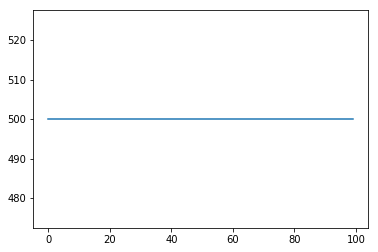

In [42]:
print(np.mean(scores))
plt.plot(scores)